<a href="https://colab.research.google.com/github/cepdnaclk/e19-co544-Bitcoin-Cost-Forecast-System/blob/main/Models/RNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary Libraries

In [73]:
import warnings  # Import the warnings module
warnings.filterwarnings("ignore")  # Ignore all warnings

import numpy as np  # Import numpy for numerical computing
import pandas as pd  # Import pandas for data manipulation
import statsmodels.api as sm  # Import statmodels for statistical models
from scipy import stats  # Import stats from SciPy for statistical functions
from sklearn.metrics import mean_squared_error  # Import mean_squared_error from sklearn for model evaluation
from math import sqrt  # Import sqrt from math for square root function
from random import randint  # Import randint from random for generating random integers

from keras.models import Sequential  # Import Sequential from keras for sequential model
from keras.layers import Dense  # Import Dense from keras for fully connected layers
from keras.layers import LSTM  # Import LSTM from keras for LSTM Layers
from keras.layers import GRU  # Import GRU from keras for GRU layers
from keras.callbacks import EarlyStopping  # Import EarlyStopping from keras for early stopping during model training
from keras import initializers  # Import initializers from keras for initializing model parameters

from matplotlib import pyplot as plt  # Import pyplot from matplotlib for plotting
from datetime import datetime  # Import datetime for date and time operations
from datetime import date # Import the date class from the datetime module

import plotly.offline as py  # Import offline module from plotly for offline plotting
import plotly.graph_objs as go  # Import graph_objs from plotly for creating plots
py.init_notebook_mode(connected=True)  # Initialize plotly notebook mode

from sklearn.preprocessing import MinMaxScaler

# %matplotlib inline  # Magic command to display matplotlib plots inline in Jupyter notebooks


# Import the Dataset

In [74]:
import yfinance as yf  # Import the yfinance module, which allows us to download historical market data from yahoo finance

# Define the ticker symbol for BitCoin
ticker = 'BTC-USD'  # Assign the string 'BTC-USD' to the variable 'ticker'.

# Get historical market data
data = yf.Ticker(ticker).history(period = 'max')

# Average Price

In [75]:
# Group the data by the 'Date' column
group = data.groupby('Date')

# Calculate the product of price and volume
data['PV'] = data['Close'] * data['Volume']

# Calculate the cumulative sum of volume
data['cumulative_volume'] = data['Volume'].cumsum()

# Calculate the cumulative sum of PV
data['cumulative_PV'] = data['PV'].cumsum()

# Calculate VWAP
data['Weighted_Price'] = data['cumulative_PV'] / data['cumulative_volume']

Daily_Price = group['Close']

Daily_Price.head(10)



Date
2014-09-17 00:00:00+00:00      457.334015
2014-09-18 00:00:00+00:00      424.440002
2014-09-19 00:00:00+00:00      394.795990
2014-09-20 00:00:00+00:00      408.903992
2014-09-21 00:00:00+00:00      398.821014
                                 ...     
2024-05-23 00:00:00+00:00    67929.562500
2024-05-24 00:00:00+00:00    68526.101562
2024-05-25 00:00:00+00:00    69265.945312
2024-05-26 00:00:00+00:00    68518.093750
2024-05-28 00:00:00+00:00    67656.632812
Name: Close, Length: 3541, dtype: float64

In [76]:
Daily_Price.tail()

Date
2014-09-17 00:00:00+00:00      457.334015
2014-09-18 00:00:00+00:00      424.440002
2014-09-19 00:00:00+00:00      394.795990
2014-09-20 00:00:00+00:00      408.903992
2014-09-21 00:00:00+00:00      398.821014
                                 ...     
2024-05-23 00:00:00+00:00    67929.562500
2024-05-24 00:00:00+00:00    68526.101562
2024-05-25 00:00:00+00:00    69265.945312
2024-05-26 00:00:00+00:00    68518.093750
2024-05-28 00:00:00+00:00    67656.632812
Name: Close, Length: 3541, dtype: float64

# Split Data

In [77]:
import yfinance as yf  # Import the yfinance module
from datetime import date
import pandas as pd

# Define the ticker symbol for Bitcoin
ticker = 'BTC-USD'

# Get historical market data
data = yf.Ticker(ticker).history(period='max')

# Calculate the product of price and volume
data['PV'] = data['Close'] * data['Volume']

# Calculate the cumulative sum of volume
data['cumulative_volume'] = data['Volume'].cumsum()

# Calculate the cumulative sum of PV
data['cumulative_PV'] = data['PV'].cumsum()

# Calculate VWAP
data['Weighted_Price'] = data['cumulative_PV'] / data['cumulative_volume']

# Use the 'Close' price as the daily price series
Daily_Price = data['Close']

# Define two dates
d0 = date(2014, 9, 17)  # Start date
d1 = date(2024, 5, 27)  # End date

# Calculate the difference between the two dates
delta = d1 - d0  # This will return a timedelta object

# Get the number of days from the timedelta object and add 1
days_look = delta.days + 1  # The '+ 1' is to include both end dates in the count

# Print the result
print(days_look)

# Repeat the process for a different date range
d0 = date(2023, 5, 17)
d1 = date(2024, 5, 27)
delta = d1 - d0
days_from_train = delta.days + 1
print(days_from_train)

# Ensure 'Daily_Price' has a datetime index
Daily_Price.index = pd.to_datetime(Daily_Price.index)

# Create the training dataset
# The training data is sliced from the 'Daily_Price' series.
df_train = Daily_Price.iloc[len(Daily_Price) - days_look : len(Daily_Price) - days_from_train]

# Create the testing dataset
# The testing data is a slice from the 'Daily_Price' series.
df_test = Daily_Price.iloc[len(Daily_Price) - days_from_train :]

# Print the length of the training and testing datasets
print(len(df_train), len(df_test))


3541
377
3164 377


# EDA

## Seasonal Decomposition

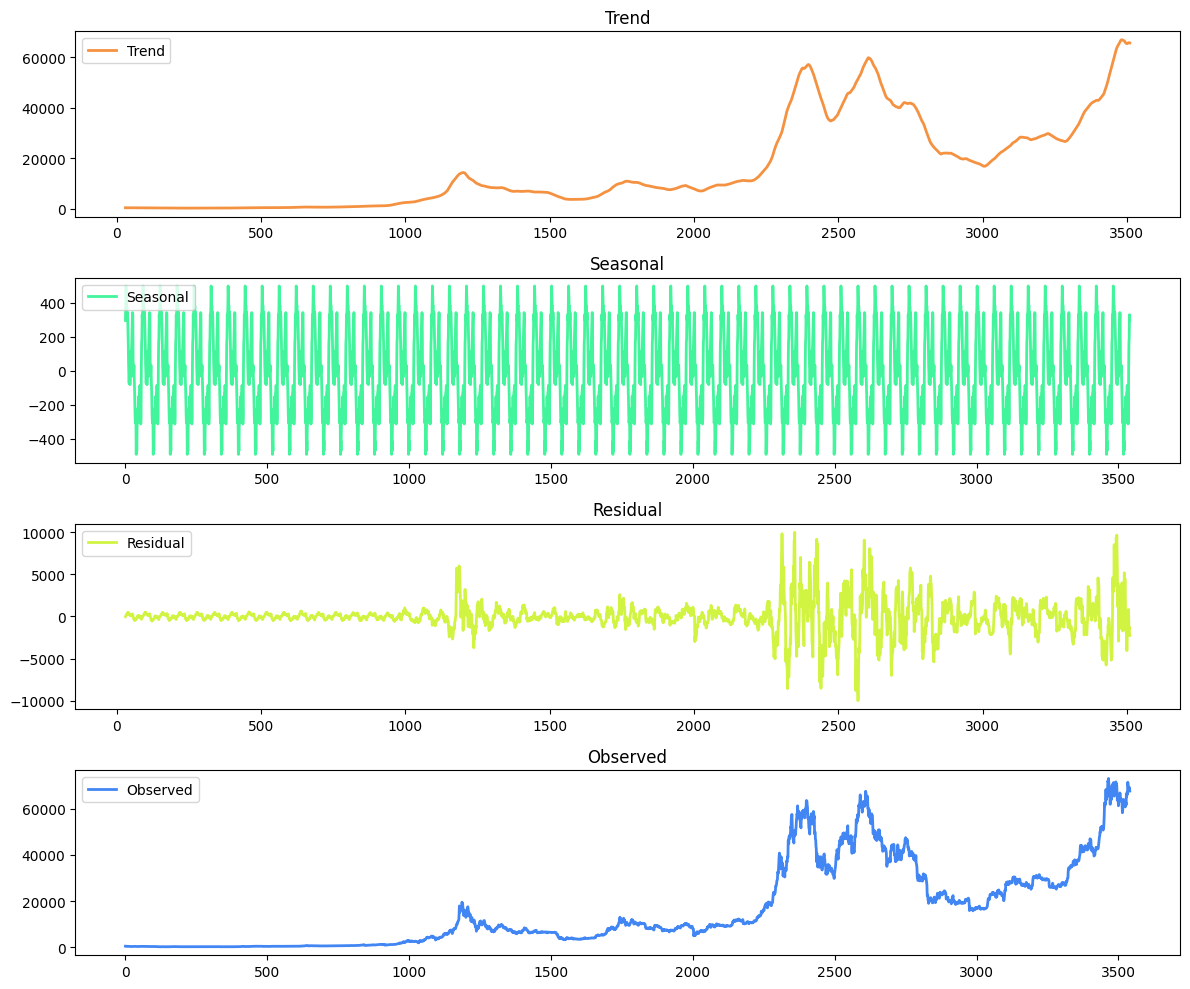

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming df_train and df_test are already defined

# Combine the training and testing datasets into a single list
working_data = [df_train, df_test]

# Concatenate the list of dataframes into a single dataframe
working_data = pd.concat(working_data)

# Reset the index of the DataFrame
working_data = working_data.reset_index()

# Convert the 'Date' column to datetime format
working_data['Date'] = pd.to_datetime(working_data['Date'])

# Set the 'Date' column as the index of the DataFrame
working_data = working_data.set_index('Date')

# Perform seasonal decomposition on the 'Weighted_Price' values using a frequency of 60 (assuming daily data)
s = sm.tsa.seasonal_decompose(working_data.Close.values, period=60)

# Plot the components
plt.figure(figsize=(12, 10))

# Trend component
plt.subplot(411)
plt.plot(s.trend, label='Trend', color=(244/255, 146/255, 65/255), linewidth=2)
plt.title('Trend')
plt.legend(loc='upper left')

# Seasonal component
plt.subplot(412)
plt.plot(s.seasonal, label='Seasonal', color=(66/255, 244/255, 155/255), linewidth=2)
plt.title('Seasonal')
plt.legend(loc='upper left')

# Residual component
plt.subplot(413)
plt.plot(s.resid, label='Residual', color=(209/255, 244/255, 66/255), linewidth=2)
plt.title('Residual')
plt.legend(loc='upper left')

# Observed component
plt.subplot(414)
plt.plot(s.observed, label='Observed', color=(66/255, 134/255, 244/255), linewidth=2)
plt.title('Observed')
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Autocorrelation

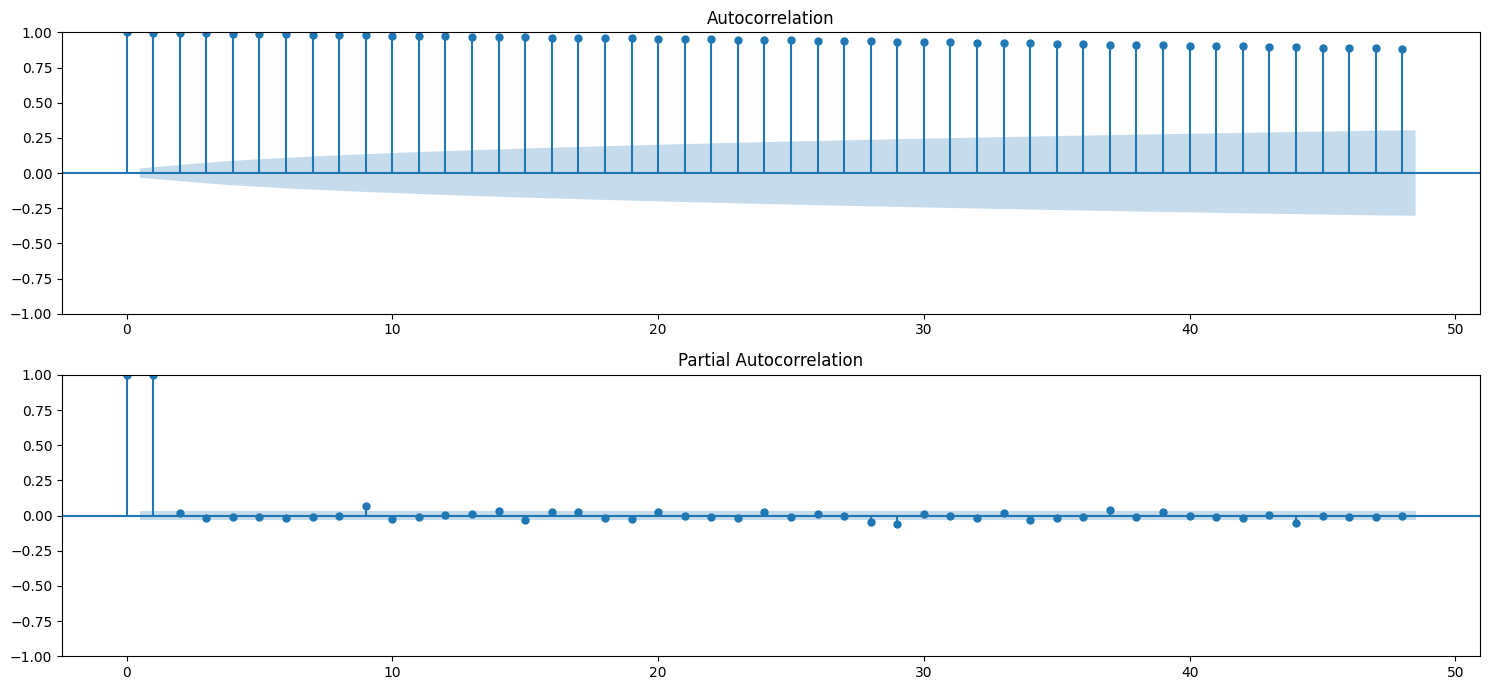

In [79]:
# Set the figure size for the plots
plt.figure(figsize=(15, 7))

# Create the first subplot (Autocorrelation plot)
ax = plt.subplot(211)

# Plot the autocorrelation function (ACF) for the'Weighted_price' values of the working_data
# 'squeeze()' is used to remove single-dimensional entries from the shape of an array
# 'lags=48' specifies the number of lags to include in the plot
sm.graphics.tsa.plot_acf(working_data.Close.values.squeeze(), lags = 48, ax = ax)

# Create the second subplot (partial Autocorrelation plot)
ax = plt.subplot(212)

# Plot the partial autocorrelation function (PACF) for the 'Weighted_Price' values of the working_data
sm.graphics.tsa.plot_pacf(working_data.Close.values.squeeze(), lags = 48, ax = ax)

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()

# Display the plots
plt.show()

# Split Training & Test Data

In [80]:
df_train = working_data[ : -60]
df_test = working_data[-60 : ]

# Data Preparation

In [81]:
def create_lookback(dataset, look_back=1):

  # Initialize empty lists to store input sequences (X) and corresponding output values (Y)
  X, Y = [], []

  # Iterate through the dataset, considering each element except the last 'look_back' elements
  for i in range(len(dataset) - look_back):

    # Extract input sequence of length 'look_back' starting from index 'i'
    a = dataset[i:(i + look_back), 0]

    # Append the input sequence to the list of input sequences (X)
    X.append(a)

    # Append the next value in the dataset after the input sequence to the list of output values (Y)
    Y.append(dataset[i + look_back, 0])

  # Convert the lists of input sequences and output values into NumPy arrays
  return np.array(X), np.array(Y)

  # Convert training dataframe to a NumPy array and reshape it to have one feature
  training_set = df_train.values
  training_set = np.reshape(training_set, (len(training_set), 1))

  # Convert test dataframe to a NumPy array and reshape it to have one feature
  test_set = df_test.values
  test_set = np.reshape(test_set, (len(test_set), 1))

  # Initialize MinMaxScaler for scaling datasets to a specified range (usually [0, 1])
  scaler = MinMaxScaler()

  # Scale the training dataset
  training_set = scaler.fit_transform(training_set)

  # Scale the test dataset (using the same scaler as for training)
  test_set = scaler.transform(test_set)

  # Define the number of previous time step to use as input for forecasting
  look_back = 1

  # Create input-output pairs suitable for time series forecasting using the defined look back
  X_train, Y_train = create_lookback(training_set, look_back)
  X_test, Y_test = create_lookback(test_set, look_back)

  # Reshape datasets to fit the requirements of the LSTM model in Keras
  # LSTM model expects input data in the shape [sample, time steps, features]
  X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

# Training 2-layers LSTM Neural Network

In [82]:
def create_lookback(dataset, look_back=1):

  # Initialize empty lists to store input sequences (X) and corresponding output values (Y)
  X, Y = [], []

  # Iterate through the dataset, considering each element except the last 'look_back' elements
  for i in range(len(dataset) - look_back):

    # Extract input sequence of length 'look_back' starting from index 'i'
    a = dataset[i:(i + look_back), 0]

    # Append the input sequence to the list of input sequences (X)
    X.append(a)

    # Append the next value in the dataset after the input sequence to the list of output values (Y)
    Y.append(dataset[i + look_back, 0])

  # Convert the lists of input sequences and output values into NumPy arrays
  return np.array(X), np.array(Y)

# Convert training dataframe to a NumPy array and reshape it to have one feature
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

# Convert test dataframe to a NumPy array and reshape it to have one feature
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

# Initialize MinMaxScaler for scaling datasets to a specified range (usually [0, 1])
scaler = MinMaxScaler()

# Scale the training dataset
training_set = scaler.fit_transform(training_set)

# Scale the test dataset (using the same scaler as for training)
test_set = scaler.transform(test_set)

# Define the number of previous time step to use as input for forecasting
look_back = 1

# Create input-output pairs suitable for time series forecasting using the defined look back
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

# Reshape datasets to fit the requirements of the LSTM model in Keras
# LSTM model expects input data in the shape [sample, time steps, features]
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

# Initialize a sequential model
model = Sequential()

# Add the first LSTM layer with 256 units, return the full sequence, and specify the input shape
model.add(LSTM(256, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))

# Add the second LSTM layer with 256 units, returning only the final output
model.add(LSTM(256))

# Add a densely connected output neuron (Dense layer) with a single unit
model.add(Dense(1))

# Compile the model specifying the loss function and the optimizer
# 'mean_squared_error' is used as the loss function and 'adam' as the optimizer
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# Fit the model to the training data, specifying the number of epochs, batch size, and validation data
history = model.fit(
    X_train, Y_train,  # Training data
    epochs = 100,  # Number of epochs to train the model
    batch_size = 16,  # Number of samples per gradient update
    shuffle = False,  # Do not shuffle the training data before each epoch
    validation_data = (X_test, Y_test),  # Data on which to evaluate the loss and any model metrics at the end of each epoch
    callbacks = [EarlyStopping(monitor = 'val_loss', min_delta=5e-5, patience = 20, verbose = 1)]  # Early stopping callback
)

# 'EarlyStopping' callback stops training when the validation loss does not improve
# 'monitor' specifies the metric to monitor
# 'min_delta' is the minimum change to qualify as an improvement
# 'patience' is the number of epochs with no improvement after which training will be stopped
# 'verbose' determine the verbosity mode (1 = progress bar)

Epoch 1/100
218/218 [==============================] - 8s 20ms/step - loss: 0.0080 - val_loss: 0.0036
Epoch 2/100
218/218 [==============================] - 4s 20ms/step - loss: 0.0082 - val_loss: 7.8582e-04
Epoch 3/100
218/218 [==============================] - 3s 15ms/step - loss: 6.7565e-04 - val_loss: 7.6378e-04
Epoch 4/100
218/218 [==============================] - 3s 15ms/step - loss: 2.0724e-04 - val_loss: 7.6714e-04
Epoch 5/100
218/218 [==============================] - 3s 15ms/step - loss: 2.3124e-04 - val_loss: 8.0918e-04
Epoch 6/100
218/218 [==============================] - 5s 21ms/step - loss: 2.2435e-04 - val_loss: 8.9527e-04
Epoch 7/100
218/218 [==============================] - 3s 14ms/step - loss: 2.0893e-04 - val_loss: 9.5096e-04
Epoch 8/100
218/218 [==============================] - 3s 15ms/step - loss: 2.0020e-04 - val_loss: 9.8509e-04
Epoch 9/100
218/218 [==============================] - 3s 15ms/step - loss: 2.1599e-04 - val_loss: 9.8373e-04
Epoch 10/100
218/218 [

# Performance Plot

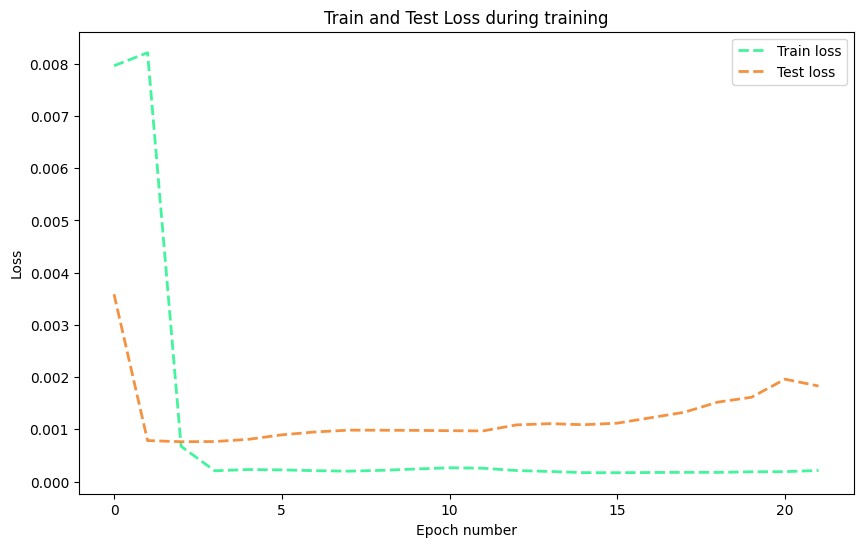

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming history is already defined and contains the training history

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(0, len(train_loss), 1)

plt.figure(figsize=(10, 6))

# Plot the training loss
plt.plot(epochs, train_loss, label='Train loss', color=(66/255, 244/255, 155/255), linewidth=2, linestyle='--')

# Plot the validation loss
plt.plot(epochs, val_loss, label='Test loss', color=(244/255, 146/255, 65/255), linewidth=2, linestyle='--')

# Add titles and labels
plt.title('Train and Test Loss during training')
plt.xlabel('Epoch number')
plt.ylabel('Loss')

# Add legend
plt.legend()

# Display the plot
plt.show()


# Prediction

In [84]:
# Add one additional data point to align shapes of the predictions and true labels
# Transform the last data point in working_data to match the scale of X_test
last_data_point = scaler.transform(working_data.iloc[-1][0].reshape(1, -1))

# Append the transformed last data point to X_test
X_test = np.append(X_test, last_data_point)

# Reshape X_test to fit the LSTM model input shape requirements: [samples, time steps, features]
X_test = np.reshape(X_test, (len(X_test), 1, 1))

# Get predictions from the model using the prepared X_test
prediction = model.predict(X_test)

# Inverse transform the predictions to return them to their original scale in USD
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))

# Inverse transform the true test labels to return them to their original scale in USD
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Align the prediction and true label arrays by removing the first prediction
# This is because we added an extra data point earlier
prediction2_inverse = np.array(prediction_inverse[:, 0][1:])

# The true labels do not need adjustment, convert to array for consistency
Y_test2_inverse = np.array(Y_test_inverse[:, 0])


2/2 [==============================] - 1s 14ms/step


# Prediction Plot

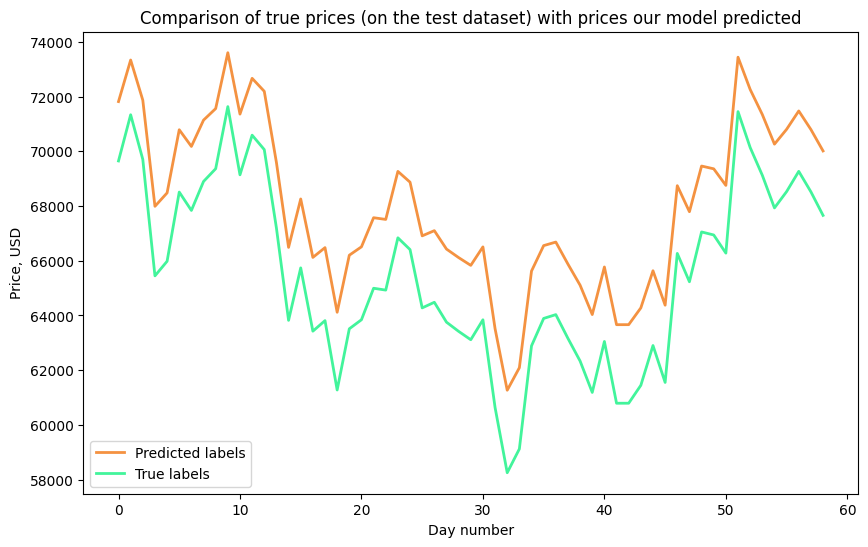

70011.47


In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming prediction2_inverse and Y_test2_inverse are already defined

# Create an array for the day numbers
days = np.arange(0, len(prediction2_inverse), 1)

plt.figure(figsize=(10, 6))

# Plot the predicted labels
plt.plot(days, prediction2_inverse, label='Predicted labels', color=(244/255, 146/255, 65/255), linewidth=2)

# Plot the true labels
plt.plot(days, Y_test2_inverse, label='True labels', color=(66/255, 244/255, 155/255), linewidth=2)

# Add titles and labels
plt.title('Comparison of true prices (on the test dataset) with prices our model predicted')
plt.xlabel('Day number')
plt.ylabel('Price, USD')

# Add legend
plt.legend()

# Display the plot
plt.show()
print(prediction2_inverse[-1])

# RMSE Calculation

In [137]:
RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
print('Test RMSE: %.3f' % (RMSE / 10000))

Test RMSE: 0.253


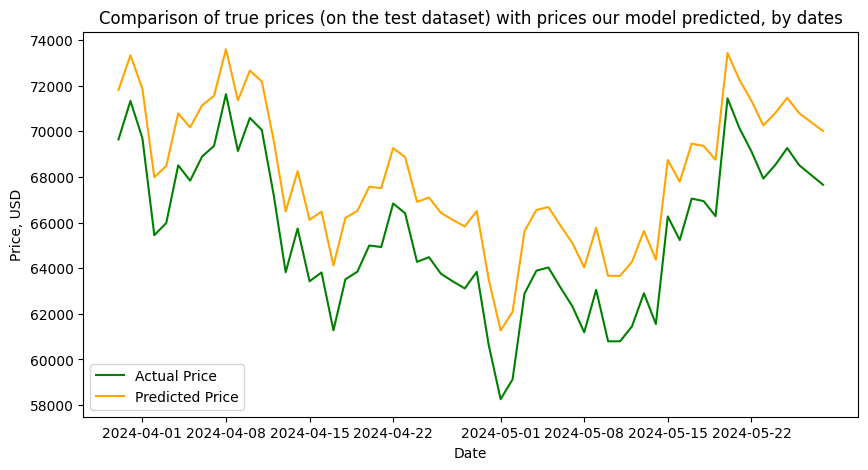

In [100]:
import matplotlib.pyplot as plt

Test_Dates = Daily_Price[len(Daily_Price)-days_from_train:].index

plt.figure(figsize=(10,5))
plt.plot(Test_Dates[-59:], Y_test2_inverse, color='g', label='Actual Price')
plt.plot(Test_Dates[-59:], prediction2_inverse, color='orange', label='Predicted Price')
plt.title('Comparison of true prices (on the test dataset) with prices our model predicted, by dates')
plt.xlabel('Date')
plt.ylabel('Price, USD')
plt.legend()
plt.show()


# GRU Layer

In [120]:
# This function prepares random train/test split,
# scales data with MinMaxScaler, create time series labels (Y)
def get_split(working_data, n_train, n_test, look_back=1):
    # get a point from which we start to take train dataset and after it - test dataset
    start_point = randint(0, len(working_data) - n_test - n_train)
    df_train = working_data[start_point:start_point + n_train]
    df_test = working_data[start_point + n_train:start_point + n_train + n_test]

    training_set = df_train.values
    training_set = np.reshape(training_set, (len(training_set), 1))
    test_set = df_test.values
    test_set = np.reshape(test_set, (len(test_set), 1))

    # scale datasets
    scaler_cv = MinMaxScaler()
    training_set = scaler_cv.fit_transform(training_set)
    test_set = scaler_cv.transform(test_set)

    # create datasets which are suitable for time series forecasting
    X_train, Y_train = create_lookback(training_set, look_back)
    X_test, Y_test = create_lookback(test_set, look_back)

    # reshape datasets so that they will be ok for the requirements of the models in Keras
    X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

    return X_train, Y_train, X_test, Y_test, scaler_cv, start_point

# This function takes datasets from the previous function as input and train model using these datasets
def train_model(X_train, Y_train, X_test, Y_test):
    # initialize sequential model, add GRU layer and densely connected output neuron
    model = Sequential()
    model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    # compile and fit the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
              validation_data=(X_test, Y_test), verbose=0,
              callbacks=[EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=0)])
    return model

# This function uses trained model and test dataset to calculate RMSE
def get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train):
    # Transform the last data point in working_data to match the scale of X_test
    additional_data_point = scaler.transform(np.array([working_data.iloc[start_point + n_train + len(X_test)]])).reshape(1, 1, 1)

    # Append the additional data point to X_test and reshape to fit the model input shape requirements: [samples, time steps, features]
    X_test = np.append(X_test, additional_data_point, axis=0)
    X_test = np.reshape(X_test, (len(X_test), 1, 1))

    # Get predictions from the model
    prediction = model.predict(X_test)

    # Reshape predictions and Y_test to 2D arrays for inverse transformation
    prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
    Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))

    # Extract the relevant parts of the inverse transformed arrays for RMSE calculation
    prediction2_inverse = np.array(prediction_inverse[:, 0][1:])
    Y_test2_inverse = np.array(Y_test_inverse[:, 0])

    # Calculate RMSE
    RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
    return RMSE, prediction2_inverse

In [121]:
def workflow(working_data, get_split, train_model, get_rmse,n_train = 250,n_test = 50,look_back = 1):
    X_train, Y_train, X_test, Y_test, scaler, start_point = get_split(working_data, n_train, n_test)
    model = train_model(X_train, Y_train, X_test, Y_test)
    RMSE, predictions = get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train)
    return RMSE, predictions

In [138]:
RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 600,n_test = 60)
print('Test GRU model RMSE: %.3f' % (RMSE / 10000))
print(prediction2_inverse)

2/2 [==============================] - 0s 8ms/step
Test GRU model RMSE: 0.024
[71815.19  73333.78  71866.5   67988.46  68479.016 70786.4   70176.31
 71137.57  71559.73  73600.34  71357.52  72664.445 72189.83  69591.266
 66487.69  68256.7   66121.16  66478.78  64116.96  66201.46  66508.16
 67571.72  67509.21  69264.01  68870.07  66909.234 67098.54  66426.38
 66114.59  65830.48  66505.89  63516.85  61267.76  62090.96  65622.76
 66552.53  66681.85  65875.75  65105.85  64033.816 65771.664 63663.24
 63664.117 64277.727 65633.57  64375.418 68741.984 67790.2   69459.766
 69358.28  68751.945 73436.4   72258.24  71342.42  70259.97  70802.06
 71472.35  70794.8   70011.47 ]


## Cross Validation

In [140]:
# This function is used to repeat the workflow ten times and to calculate average RMSE
def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 250,n_test = 50,look_back = 1):
    rmse_list = []
    for i in range(8):
        print('Iteration:', i+1)
        RMSE, _ = workflow(working_data, get_split, train_model, get_rmse, n_train, n_test, look_back)
        rmse_list.append(RMSE / 10000)
        print('Test RMSE: %.3f' % (RMSE / 10000))
    mean_rmse = np.mean(rmse_list)
    return mean_rmse, rmse_list

mean_rmse, rmse_list = cross_validate(working_data, get_split, train_model, get_rmse, workflow)
print('Average RMSE: ', mean_rmse)
print('RMSE list:', rmse_list)

Iteration: 1
2/2 [==============================] - 1s 8ms/step
Test RMSE: 0.014
Iteration: 2
2/2 [==============================] - 0s 6ms/step
Test RMSE: 0.045
Iteration: 3
2/2 [==============================] - 1s 9ms/step
Test RMSE: 0.002
Iteration: 4
2/2 [==============================] - 1s 10ms/step
Test RMSE: 0.000
Iteration: 5
2/2 [==============================] - 0s 7ms/step
Test RMSE: 0.049
Iteration: 6
2/2 [==============================] - 0s 5ms/step
Test RMSE: 0.054
Iteration: 7
2/2 [==============================] - 1s 8ms/step
Test RMSE: 0.009
Iteration: 8
2/2 [==============================] - 0s 6ms/step
Test RMSE: 0.000
Average RMSE:  0.021598848854160937
RMSE list: [0.013982031512889804, 0.04495126625853409, 0.0021887840383840876, 0.000332922276638964, 0.048762117752772116, 0.05360259713815663, 0.008959868617629093, 1.1203238282705727e-05]


In [131]:
# calculate the range of your data
data_range = np.max(Y_test2_inverse) - np.min(Y_test2_inverse)

# calculate RMSE
RMSE_new = np.sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))

# normalize RMSE
RMSE_normalized = RMSE_new / data_range

print('Normalized Test GRU model RMSE: %.3f' % RMSE_normalized)

Normalized Test GRU model RMSE: 0.189


# Prediction Plot

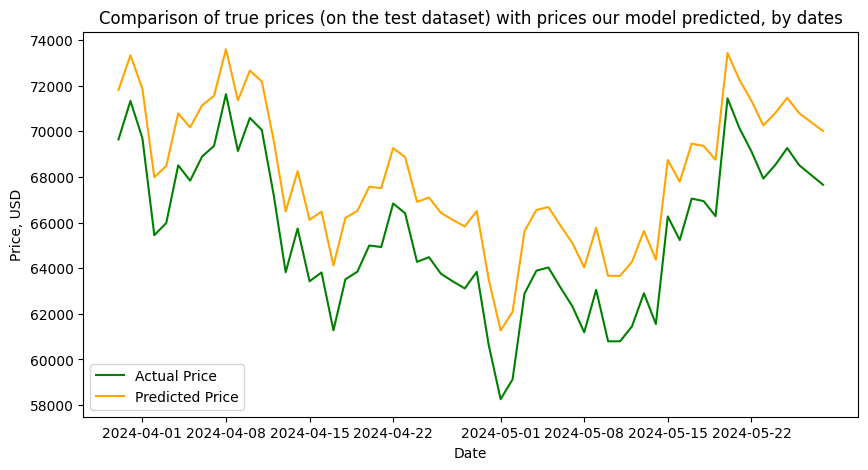

In [141]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10,5))

# Plot the actual prices
plt.plot(Test_Dates[-59:], Y_test2_inverse, color='g', label='Actual Price')

# Plot the predicted prices
plt.plot(Test_Dates[-59:], prediction2_inverse, color='orange', label='Predicted Price')

# Set the title and labels
plt.title('Comparison of true prices (on the test dataset) with prices our model predicted, by dates')
plt.xlabel('Date')
plt.ylabel('Price, USD')

# Show the legend
plt.legend()

# Show the plot
plt.show()


## MAPE

In [142]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred, epsilon = 1e-8):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2 + epsilon)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(Y_test2_inverse, prediction2_inverse)

print('Test SMAPE (percentage): %.3f' % SMAPE)

Test SMAPE (percentage): 3.787
